In [3]:
import pickle
import hopsworks

In [6]:
project = hopsworks.login(api_key_value="wOWQmzzHeITT5wlJ.FkOButuQ3XpDXSUO1LnTuaNfD7SPWolfF1hateoistsLFFsBF7upULn5z6qKPOIB")
fs = project.get_feature_store() 
headline_fg = fs.get_feature_group(
    name='headlines_new', 
    version=1,
)
mr = project.get_model_registry()

model = mr.get_model("PCA_Model", version=1)
model_dir = model.download()
print(f"Model downloaded to: {model_dir}")
with open(f"{model_dir}/pca_model.pkl", "rb") as f:
    pca_model = pickle.load(f)
    
model = mr.get_model("KMeans_Model", version=1)
model_dir = model.download()
print(f"Model downloaded to: {model_dir}")
with open(f"{model_dir}/kmeans_model.pkl", "rb") as f:
    kmeans_model = pickle.load(f)

2024-12-03 22:20:49,370 INFO: Closing external client and cleaning up certificates.
Connection closed.
2024-12-03 22:20:49,379 INFO: Initializing external client
2024-12-03 22:20:49,380 INFO: Base URL: https://c.app.hopsworks.ai:443
2024-12-03 22:20:50,527 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1163414
Model downloaded to: /var/tmp/79e61a86-f766-4b93-8ba1-996c01edff52/PCA_Model/1
Model downloaded to: /var/tmp/647cacee-69ef-4b90-9850-9e58c0706e8a/KMeans_Model/1


In [9]:
print(pca_model, kmeans_model)

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')


PCA(n_components=2) KMeans(n_clusters=4, random_state=22)
2024-12-03 22:24:15,981 INFO: Use pytorch device_name: cpu
2024-12-03 22:24:15,985 INFO: Load pretrained SentenceTransformer: all-MiniLM-L6-v2


In [53]:
emb =  model.encode([' Was Daniel Penny reckless? Jurors to decid', 'this'])
print(emb[0,0:10], len(emb))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[-0.06804226  0.08991811  0.00630171 -0.0520573  -0.00493738 -0.02730278
  0.06904142 -0.02350643 -0.02551715  0.03519316] 2


In [54]:
import numpy as np
clusters = kmeans_model.predict(emb)

embeddings_2d =pca_model.transform(emb)
print(preds, dims)

[3 2] [[-0.11867069 -0.2128431 ]
 [ 0.04452433  0.03275317]]


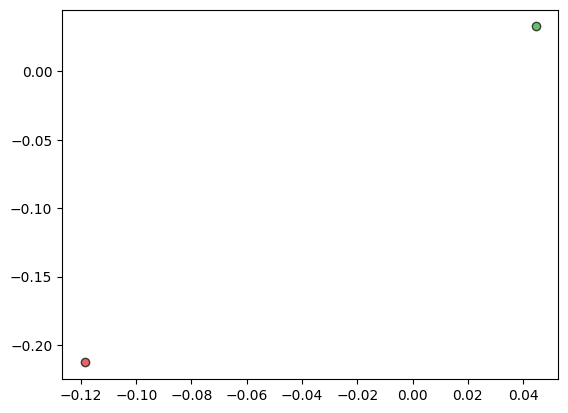

In [55]:
import matplotlib.pyplot as plt
for cluster in range(4):
    cluster_points = embeddings_2d[clusters == cluster]
    plt.scatter(
        cluster_points[:, 0], cluster_points[:, 1],
        label=f"Cluster {1}", alpha=0.7, edgecolors='k'
    )


In [70]:
project = hopsworks.login(api_key_value="wOWQmzzHeITT5wlJ.FkOButuQ3XpDXSUO1LnTuaNfD7SPWolfF1hateoistsLFFsBF7upULn5z6qKPOIB")
fs = project.get_feature_store() 
headline_fg = fs.get_feature_group(
    name='headlines_new', 
    version=1,
)
headline_df = headline_fg.read()
headline_df = headline_df.sort_values(by='pubdate')

2024-12-03 23:10:58,908 INFO: Closing external client and cleaning up certificates.
Connection closed.
2024-12-03 23:10:58,917 INFO: Initializing external client
2024-12-03 23:10:58,918 INFO: Base URL: https://c.app.hopsworks.ai:443
2024-12-03 23:10:59,981 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1163414
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.19s) 


In [81]:
def df_between_dates(df, start_date, end_date):
    return df[(df['pubdate'] >= start_date) & (df['pubdate'] <= end_date)]
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
now = datetime.now()
past_week = now + timedelta(weeks=-1)
df_week = df_between_dates(headline_df, past_week.strftime("%Y-%m-%d"), now.strftime("%Y-%m-%d"))

                        pubdate  \
14702 2024-12-03 00:00:00+00:00   
14703 2024-12-03 00:00:00+00:00   
14704 2024-12-03 00:00:00+00:00   
14705 2024-12-03 00:00:00+00:00   
14707 2024-12-03 00:00:00+00:00   

                                                   title  
14702  Premier League: Leicester 3-0 up against West ...  
14703  Was Daniel Penny 'reckless'? Jurors to decide ...  
14704  Why South Korea's president suddenly declared ...  
14705  Killer in femicide that shocked Italy sentence...  
14707  Afghan women 'banned from midwife courses' in ...  
                        pubdate  \
14702 2024-12-03 00:00:00+00:00   
14703 2024-12-03 00:00:00+00:00   
14704 2024-12-03 00:00:00+00:00   
14705 2024-12-03 00:00:00+00:00   
14707 2024-12-03 00:00:00+00:00   

                                                   title  
14702  Premier League: Leicester 3-0 up against West ...  
14703  Was Daniel Penny 'reckless'? Jurors to decide ...  
14704  Why South Korea's president suddenly dec

In [111]:
def get_most_similar_headlines(query_embedding, embeddings, headlines, top_n=5):
    print('compute similarities')
    similarities = cosine_similarity(query_embedding, embeddings)[0]
    top_indices = np.argsort(-similarities)[:top_n]
    return [(headlines[i], similarities[i]) for i in top_indices]

def compare(encoded_headlines, query):
    most_similar = get_most_similar_headlines(model.encode([query]), encoded_headlines, headlines, top_n=5)
    print(f"Query: {query}")
    print("Most Similar Headlines:")
    for i, (headline, similarity) in enumerate(most_similar, 1):
        print(f"{i}. {headline} (Similarity: {similarity:.4f})")

In [98]:
encoded_headlines = model.encode(headline_df['title'].to_list())
#load this from hopsworks?

Batches:   0%|          | 0/460 [00:00<?, ?it/s]

In [114]:
# TODO do this only for the ones in the k mean cluster, Mad fast anyway
compare(encoded_headlines, "who will win election")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

compute similarities
Query: who will win election
Most Similar Headlines:
1. 14 days until the election... Who's winning? (Similarity: 0.7113)
2. General election: When is the next one and who decides? (Similarity: 0.6463)
3. Who can I vote for in the general election? (Similarity: 0.6423)
4. Local elections 2024: Who can I vote for? (Similarity: 0.6363)
5. When is the next general election? (Similarity: 0.6083)


In [115]:
print(len(headline_df))
print(encoded_headlines.shape)

14708
(14708, 384)


In [103]:
import sys

In [106]:
#size mb
print(sys.getsizeof(headline_df)/ (1024**2))
print(sys.getsizeof(encoded_headlines)/ (1024**2))

1.8910598754882812
21.5450439453125


In [118]:
import pandas as pd
column_names = [f"dim_{i}" for i in range(384)]
df = pd.DataFrame(encoded_headlines, columns=column_names)

df["id"] = range(len(df))
feature_group = fs.get_or_create_feature_group(
    name="high_dimensional_vectors",
    version=1,
    description="Feature group for 384-dimensional vectors",
    primary_key=["id"], 
    online_enabled=True 
)
feature_group.insert(df, write_options={"wait_for_job": True})

print("240-dimensional vectors successfully written to Hopsworks Feature Store.")

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1163414/fs/1154117/fg/1378788


Uploading Dataframe: 100.00% |██████████| Rows 14708/14708 | Elapsed Time: 01:32 | Remaining Time: 00:00


Launching job: high_dimensional_vectors_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1163414/jobs/named/high_dimensional_vectors_1_offline_fg_materialization/executions
2024-12-04 00:06:27,335 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2024-12-04 00:06:33,626 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2024-12-04 00:10:41,499 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2024-12-04 00:10:41,631 INFO: Waiting for log aggregation to finish.
2024-12-04 00:10:50,125 INFO: Execution finished successfully.
240-dimensional vectors successfully written to Hopsworks Feature Store.


In [130]:
fg_vectors = fs.get_feature_group(
    name='high_dimensional_vectors', 
    version=1,
)
retrieved_data = fg_vectors.read()
vector_columns = [f"dim_{i}" for i in range(240)]
vectors = retrieved_data[vector_columns].to_numpy()
print(vectors.shape)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.79s) 
(14708, 240)
